In [1]:
import os
import numpy as np
import xarray as xr
# import xarray_regrid
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from glob import glob
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from index_long_names import long_names

ERROR 1: PROJ: proj_create_from_database: Open of /home/b/b381815/miniconda3/envs/py/share/proj failed


In [2]:
def plot_map(ax, da, **kwargs):
    if 'cmap' not in kwargs:
        kwargs['cbar_kwargs'] = {'pad': .01}
    map_ = da.plot.pcolormesh(ax=ax, **kwargs)       
    ax.coastlines()
    ax.set_ylabel('')
    ax.set_title('')
    map_.colorbar.set_label('')
    return ax, map_

def area_weighted_mean(da):   
    cell_area = np.cos(np.deg2rad(da['lat']))
    return da.weighted(cell_area).mean(dim=('lat', 'lon'), keep_attrs=True)

In [3]:
path = '/work/uc1275/LukasBrunner/data/SarahKang/CESM2-LE/ETCCDI'

In [4]:
# etccdi_indices = [
#     'cdd',  'cwd', 'prcptot', 'r10mm', 'r20mm', 'r95p', 'r99p', 'rx1day', 'rx5day', 'sdii',  # pr-based 
#     'csdi', 'fd', 'id', 'tn10p', 'tn90p', 'tnn', 'tnx', 'tr',  # tasmin-based
#     'su', 'tx10p', 'tx90p', 'txn', 'txx', 'wsdi',  # tasmax-based
#     'dtr',  # tasmin & tasmax
#     'gsl',  # tas
# ]
# # len(etccdi_indices)

# re-sort to have similar indices beside each other
etccdi_indices = [
    'tn10p', 'tn90p', 'tnn', 'tnx',
    'tx10p', 'tx90p', 'txn', 'txx',
    'csdi', 'wsdi', 'id', 'su',
    'prcptot', 'sdii', 'cdd', 'cwd',
    'r95p', 'r99p', 'r10mm', 'r20mm',  
    'rx1day', 'rx5day', 'fd', 'tr',
    'dtr', 'gsl', '10p', '90p',
]

In [5]:
cbar_limits = {}

# # percentile-based indices
# for index in ['tn10p', 'tn90p', 'tx10p', 'tx90p']:
#     cbar_limits[index] = dict(
#         vmin=10,
#         vmax=12,
#     )

# for index in ['tnn', 'tnx', 'txn', 'txx']:
#     cbar_limits[index] = dict(
#         vmin=-30,
#         vmax=30,
#     )

# for index in ['cdd', 'cwd']:
#     cbar_limits[index] = dict(
#         vmin=20,
#         vmax=100,
#     )


## Load data

In [6]:
dict_cdo = {}
dict_freq = {}

fn_pattern = '{index}ETCCDI_*.nc'
for index in etccdi_indices:
    # print(index)
    fns = glob(os.path.join(path, fn_pattern.format(index=index)))
    if len(fns) != 1:
        print(f'Error in finding file for {index=}')
        continue
    else:
        print(f'Reading {index=}')

    try:
        da = xr.open_dataset(fns[0], decode_timedelta=False, use_cftime=True)[f'{index}ETCCDI']
    except Exception as ex:
        print(f'Error in reading file for {index=}')
        print(ex)
        continue
    
    if da.attrs['units'] == 'm/s':  # adjust units to better interpretable ones
        da.values *= 60*60*24 * 1000
        da.attrs['units'] = 'mm/day'
    if da.attrs['units'] == 'K':
        if index != 'dtr':
            da.values -= 273.15
        da.attrs['units'] = 'degC'
        
    freq = 'MON' if 'mon' in fns[0] else 'ANN'

    dict_cdo[index] = da
    dict_freq[index] = freq
    

Reading index='tn10p'
Reading index='tn90p'
Reading index='tnn'
Reading index='tnx'
Reading index='tx10p'
Reading index='tx90p'
Reading index='txn'
Reading index='txx'
Reading index='csdi'
Reading index='wsdi'
Reading index='id'
Error in reading file for index='id'
Failed to decode variable 'time': unable to decode time units 'days since 1677-3-44 00:00:00' with "calendar '365_day'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.
Reading index='su'
Reading index='prcptot'
Reading index='sdii'
Reading index='cdd'
Reading index='cwd'
Reading index='r95p'
Reading index='r99p'
Reading index='r10mm'
Reading index='r20mm'
Reading index='rx1day'
Reading index='rx5day'
Reading index='fd'
Reading index='tr'
Reading index='dtr'
Error in finding file for index='gsl'
Reading index='10p'
Reading index='90p'


In [7]:
# WHY THE IS THIS HAPPENING?????
ds = xr.open_dataset(glob(os.path.join(path, fn_pattern.format(index='id')))[0], decode_times=False)
print(ds['time'].attrs['units'])
# xr.decode_cf(ds, use_cftime=True)

# ds = ds.assign_coords({'time': xr.cftime_range(start='1979-01-01', periods=ds['time'].size, freq='1ME')})
# print(ds['time'])
# dict_cdo['id'] = ds['idETCCDI']
# dict_freq['id'] = 'mon'

days since 1677-3-44 00:00:00


## Plot maps

In [8]:
period = slice('1979', '2013')

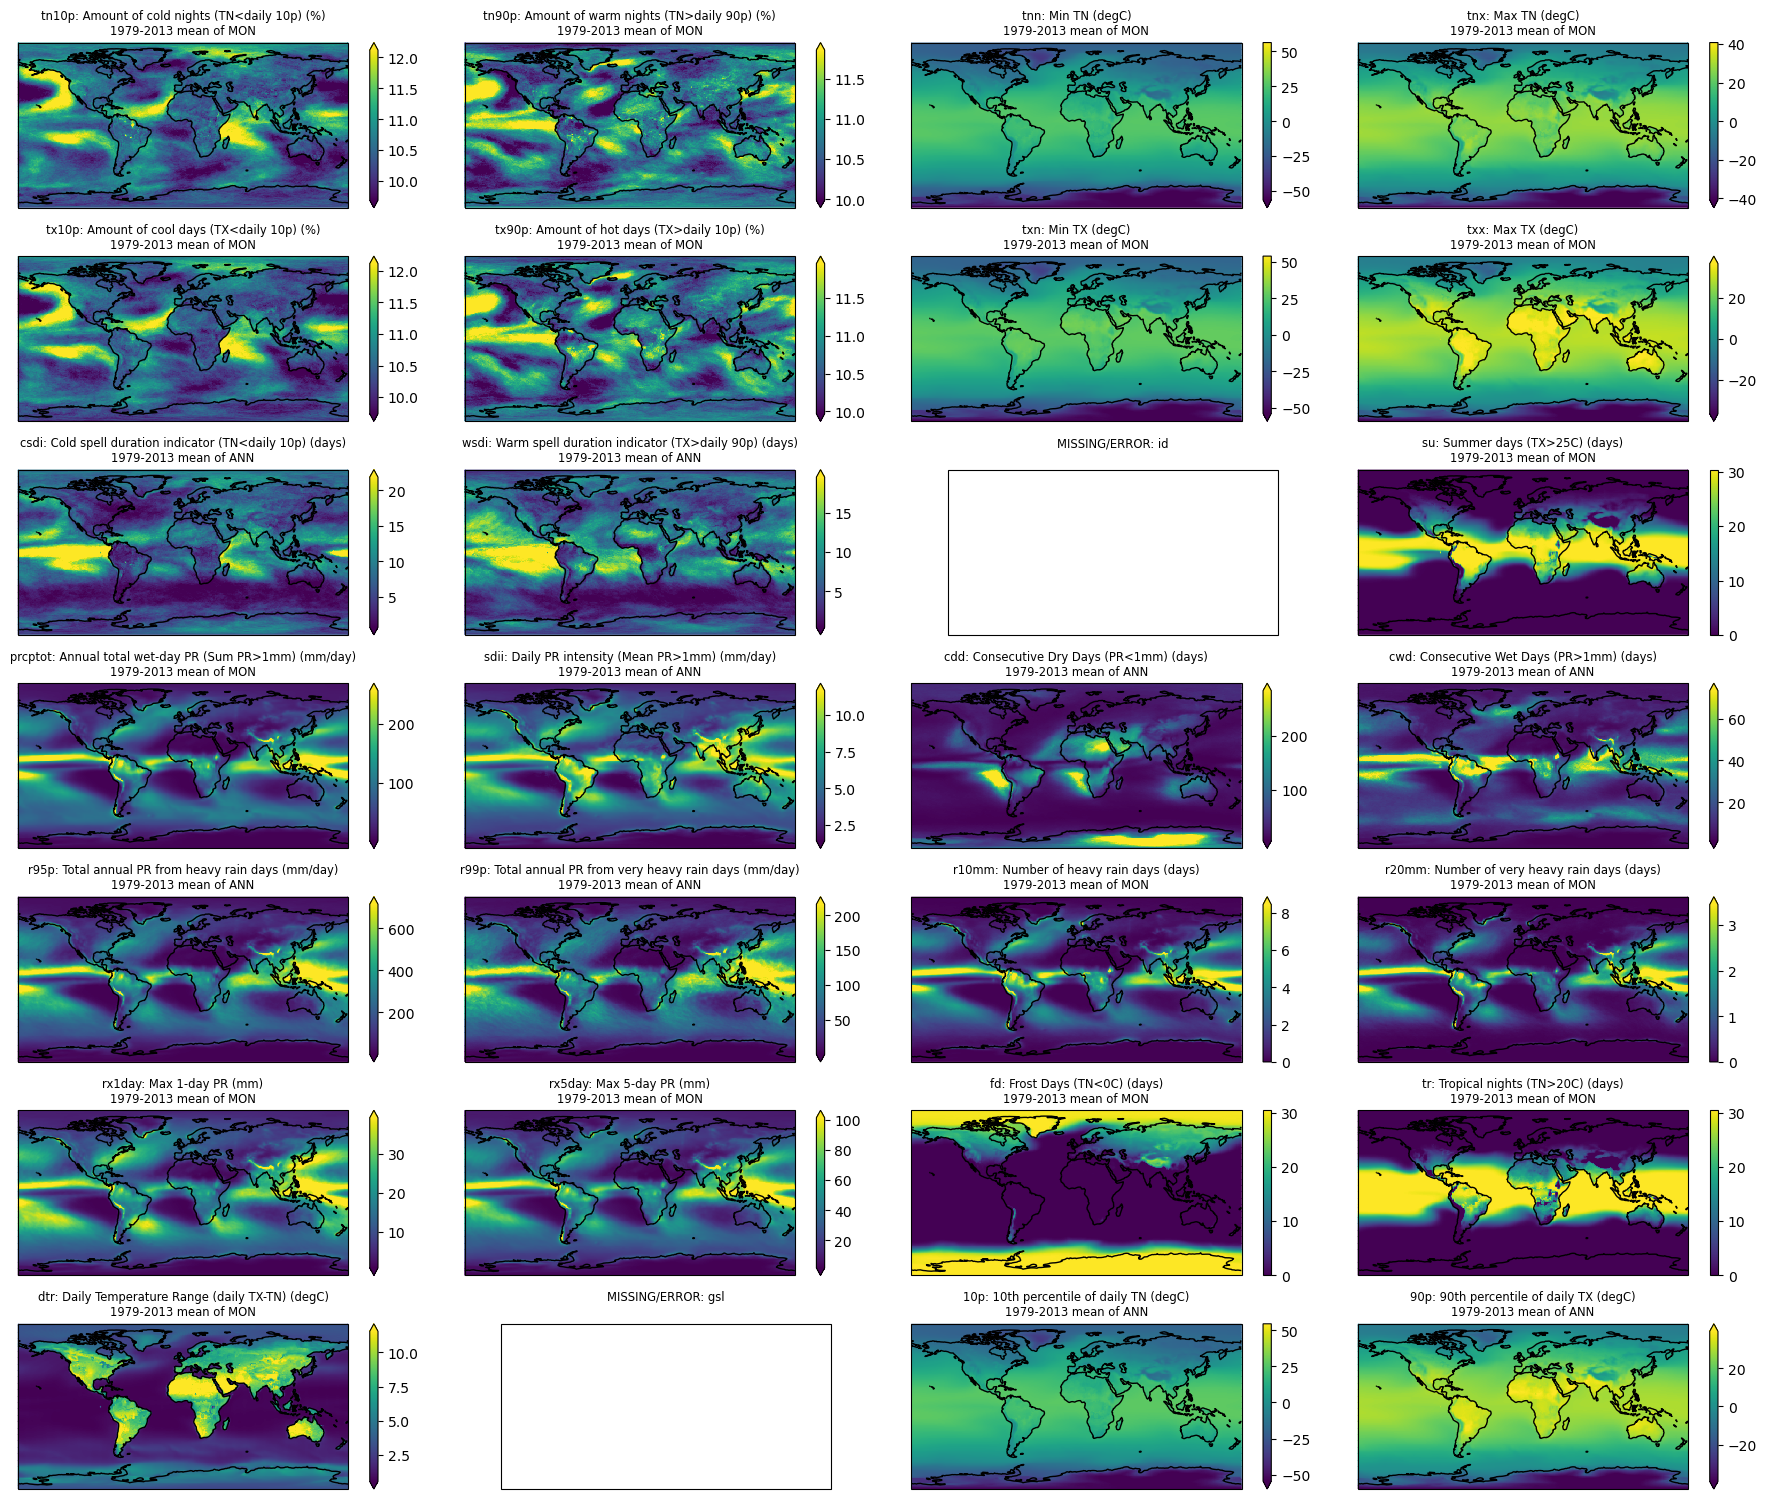

In [9]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(7, 4, subplot_kw={'projection': proj}, figsize=(18, 15))

for idx, index in enumerate(etccdi_indices):
    ax = axes.ravel()[idx]
    
    if index not in dict_cdo.keys():
        ax.set_title(f'MISSING/ERROR: {index}\n', fontsize='small')
        continue
    da = dict_cdo[index]
    if index in ['10p', '90p']: 
        da = da.mean('time', keep_attrs=True) 
    else:
        da = da.sel(time=period).mean('time', keep_attrs=True) 
        
    plot_map(ax, da, robust=True, cmap='viridis', **cbar_limits.get(index, {}))
    ax.set_title(
        '{}: {} ({})\n{}-{} mean of {}'.format(
            index, long_names[index], da.attrs['units'],
            period.start, period.stop, dict_freq[index],
        ),
        # wrap=True
        fontsize='small',
    )

idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1

fig.tight_layout()

## Lineplots

In [10]:
y_limits = {}

# # percentile-based indices
# for index in ['tn10p', 'tn90p', 'tx10p', 'tx90p']:
#     y_limits[index] = (0, 25)

# for index in ['tnn', 'tnx', 'txn', 'txx']:
#     y_limits[index] = (10, 20)

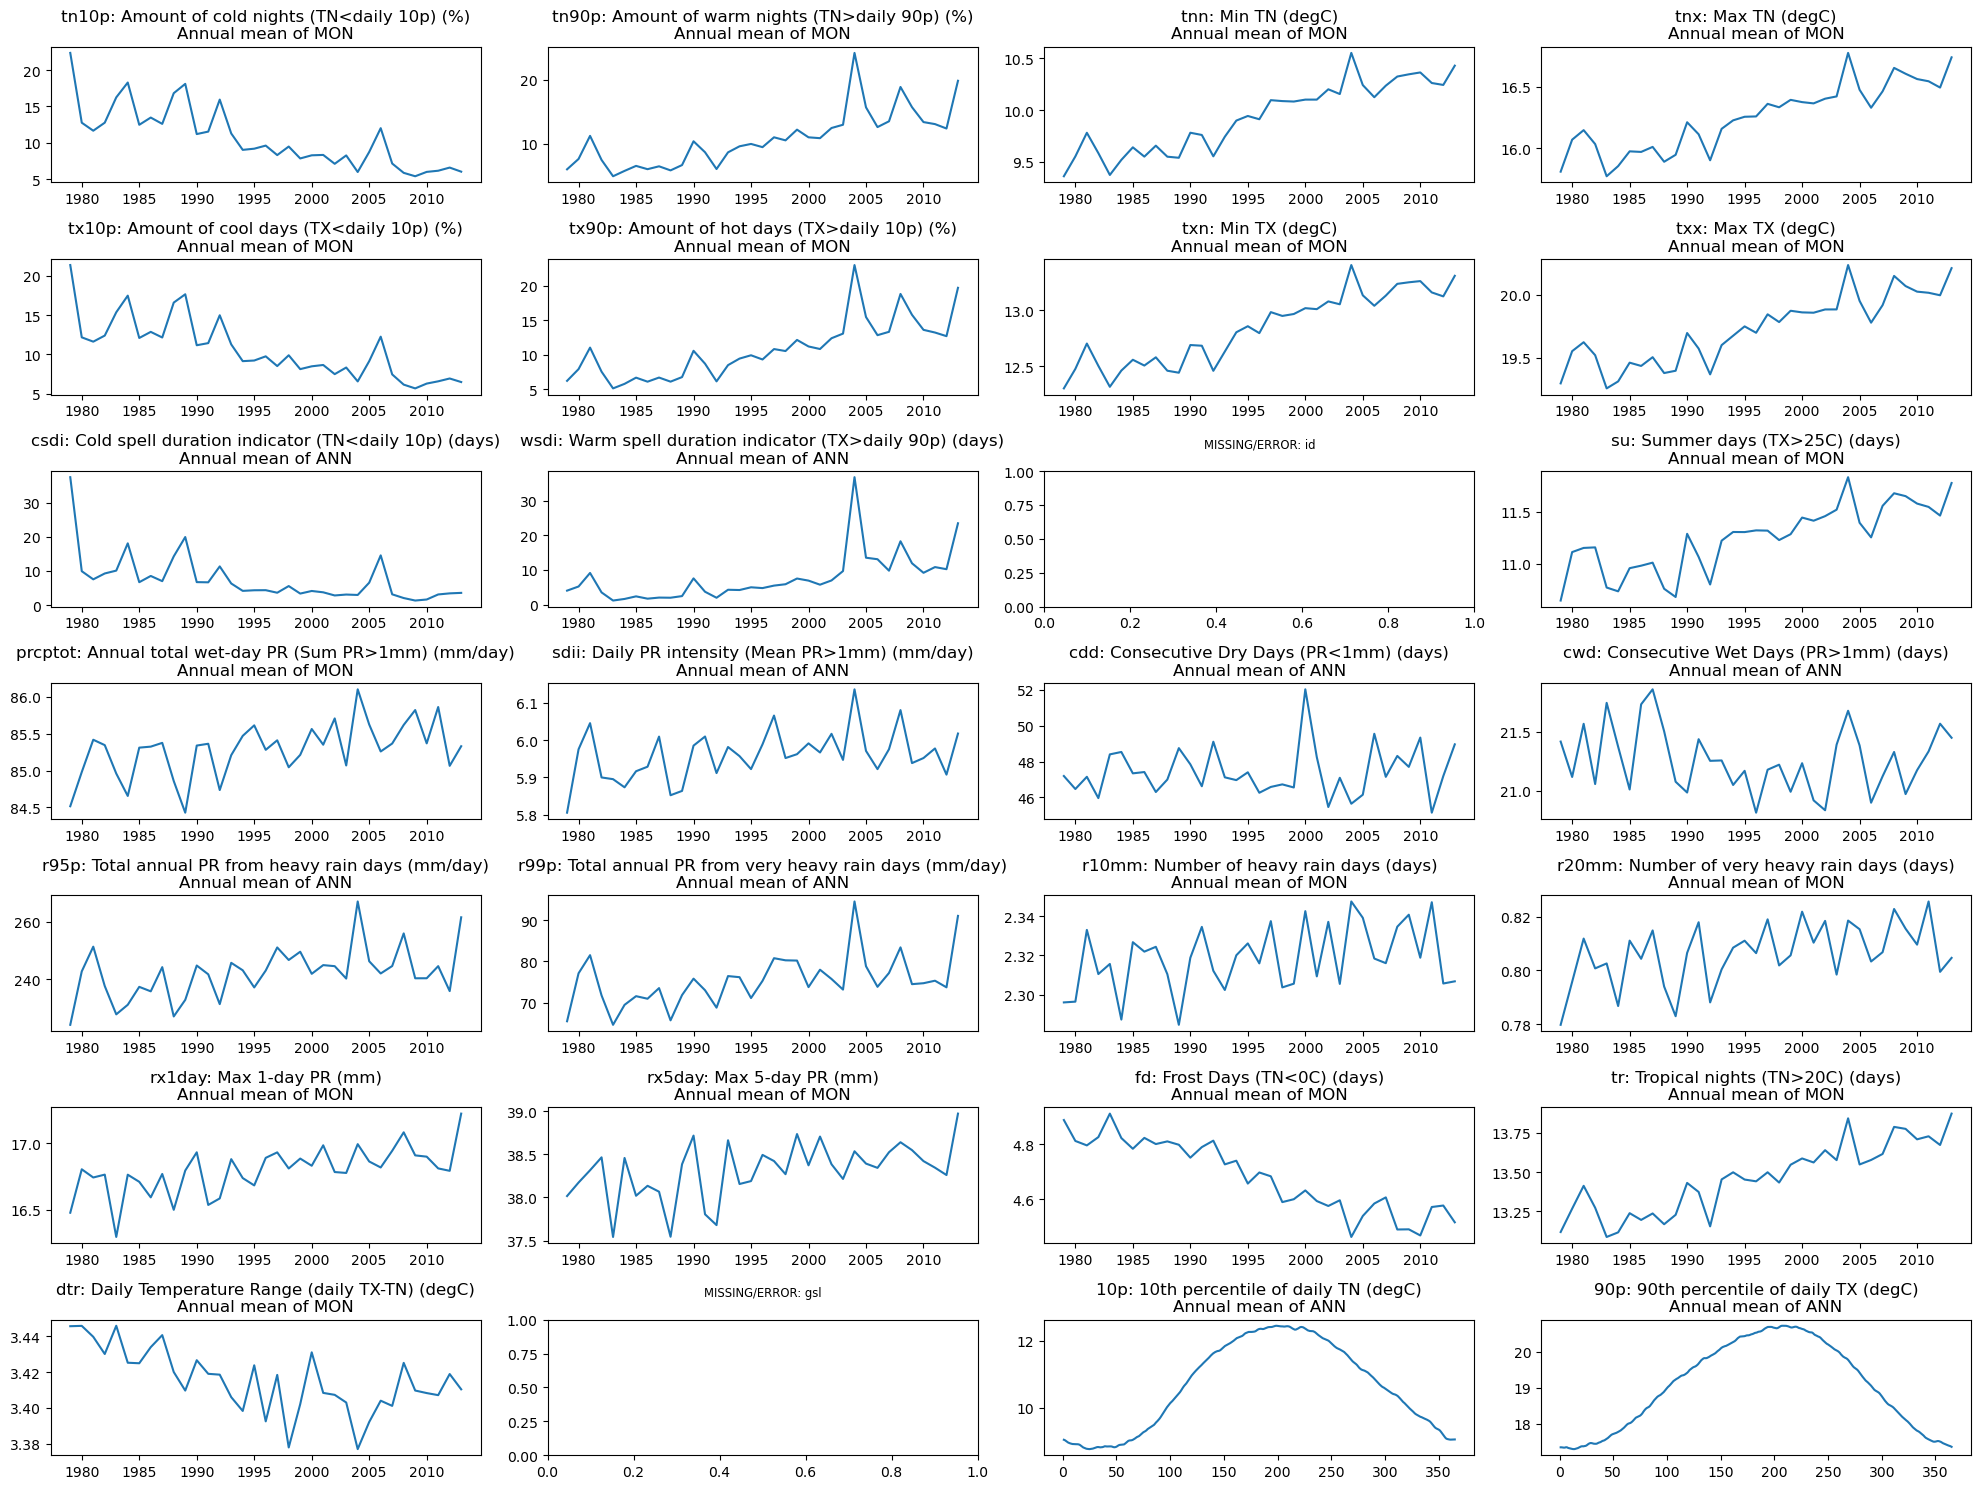

In [11]:
fig, axes = plt.subplots(7, 4, figsize=(20, 15))

for idx, index in enumerate(etccdi_indices):
    ax = axes.ravel()[idx]
    
    if index not in dict_cdo.keys():
        ax.set_title(f'MISSING/ERROR: {index}\n', fontsize='small')
        continue
    # print(index)
    da = dict_cdo[index]
    
    if index in ['10p', '90p']: 
        da = area_weighted_mean(da.groupby('time.dayofyear').mean())
        hh1, = ax.plot(da['dayofyear'], da, label='cdo')
    else:
        da = area_weighted_mean(da.sel(time=period).groupby('time.year').mean())
        hh1, = ax.plot(da['year'], da, label='cdo')

    if index in y_limits.keys():
        ax.set_ylim(y_limits[index])
    
    ax.set_title('{}: {} ({})\n{} mean of {}'.format(
        index, long_names[index], da.attrs['units'],
        'Annual', dict_freq[index],
    ))

# idx += 1
# ax = axes.ravel()[idx]
# ax.axis('off')

idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1
    
fig.tight_layout() 

## Comparison to ClimDexCalc2 - MPI-ESM1-2-LR

Here we could compare any output with the output from ClimDexCalc2 for MPI-ESM1-2-LR. But it needs to be on the same grid. Unfortunately xarray-regrid as a version conflict in my current environment. 

TODO: fix at some point...

In [12]:
# dict_cdc = {}

# fn_pattern = '/work/uc1275/LukasBrunner/data/etccdi_cdo/climdexcalc2_test/{index}_{freq}_*.nc'

# for idx, index in enumerate(etccdi_indices):
#     ax = axes.ravel()[idx]
    
#     if index not in dict_cdo.keys():
#         ax.set_title(f'MISSING/ERROR: {index}\n', fontsize='small')
#         continue
        
#     fns = glob(os.path.join(path, 'climdexcalc2_test', fn_pattern.format(index=index, freq=dict_freq[index].upper())))
#     if len(fns) != 1:
#         print(fns)
#         raise ValueError

#     da = dict_cdo[index]
#     ref = xr.open_dataset(fns[0], decode_timedelta=False)[f'{index}']
#     ref = ref.regrid.linear(da)

#     if index in ['10p', '90p']: 
#         da = da.mean('time', keep_attrs=True) 
#         ref = ref.mean('time', keep_attrs=True) 
#     else:
#         da = da.sel(time=period).mean('time', keep_attrs=True) 
#         ref = ref.sel(time=period).mean('time', keep_attrs=True) 
        

#     plot_map(ax, da - ref, robust=True, cmap='RdBu_r', center=0)

    